In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
from tqdm import tqdm

In [6]:
dataset_name = 'ravdess'
experiment_prefix = 'trillsson_fusion'
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'

In [9]:
data_dir = f'../data/data_preprocessed/{dataset_name}/features/'
sr = 16000

data_x = np.load(f'{data_dir}{dataset_name}.audio16k.npy', allow_pickle=True)
data_x_emb = np.load(f'{data_dir}{dataset_name}.embedding.trillsson.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}{dataset_name}.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}{dataset_name}.classnames.npy', allow_pickle=True)
print(classnames)
print(data_x.shape, data_x_emb.shape)
print(data_y.shape, np.unique(data_y))

['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']
(1440,) (1440, 1024)
(1440,) [0 1 2 3 4 5 6 7]


In [10]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_filter(idx):
    return classnames[idx][:3] in labels

def label_to_index(idx):
    return labels.index(classnames[idx][:3])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_x_emb = data_x_emb[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(672,)


In [15]:
from IConNet.acov.model import SCB7

In [16]:
in_channels = 1
out_channels = 8
embedding_dim = 1023
num_embeddings = 384
commitment_cost = 0.25
learning_rate = 1e-4
num_tokens = 256
num_classes = 4

codebook_pretrained_path = f'../scb7_models/ravdess/codebook.step=10000.pt'
model = SCB7(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=False,
    loss_type='signal_loss',
)

In [17]:
checkpoint_path = '../scb7_models/ravdess/scb7.model.ravdess.step10000.pt'
pretrained_model = torch.load(checkpoint_path)

In [18]:
model.load_state_dict(pretrained_model)

RuntimeError: Error(s) in loading state_dict for SCB7:
	Missing key(s) in state_dict: "zero_loss", "classifier.0.weight", "classifier.0.bias", "classifier.1.weight", "classifier.2.weight", "classifier.3.weight", "classifier.3.bias", "encoder.vq.window", "encoder.vq.embedding.weight", "ffn.0.weight", "ffn.0.bias", "ffn.1.ffn.0.weight", "ffn.1.ffn.0.bias", "ffn.1.ffn.2.weight", "ffn.1.ffn.2.bias". 
	Unexpected key(s) in state_dict: "vq_vae.embedding.weight", "ln1.weight", "ln1.bias", "encoder.position_concentration", "ffn.ffn.0.weight", "ffn.ffn.0.bias", "ffn.ffn.2.weight", "ffn.ffn.2.bias". 

In [19]:
pretrained_model

OrderedDict([('encoder.position_concentration',
              tensor([0.5361, 0.4605, 0.8003, 0.6098, 0.3951, 0.3098, 0.8126, 0.7925],
                     device='cuda:0')),
             ('vq_vae.embedding.weight',
              tensor([[ 0.0263,  0.0264,  0.0848,  ...,  0.0655,  0.0620,  0.0848],
                      [-0.0021, -0.0069, -0.0082,  ..., -0.0202,  0.0035, -0.0165],
                      [-0.0281,  0.0304,  0.0310,  ...,  0.0315,  0.0319,  0.0330],
                      ...,
                      [ 0.0200,  0.0197,  0.0201,  ...,  0.0200, -0.0191, -0.0195],
                      [-0.0124, -0.0354, -0.0361,  ..., -0.0708, -0.0651, -0.0368],
                      [-0.0439, -0.0171, -0.0211,  ..., -0.0009, -0.0058, -0.0135]],
                     device='cuda:0')),
             ('ffn.ffn.0.weight',
              tensor([[-5.8077e-02,  2.3339e-03, -3.4418e-02,  ..., -1.5382e-02,
                       -6.7208e-02, -4.7932e-03],
                      [-9.0912e-02, -3.9900e-02

In [20]:
pretrained_model.keys()

odict_keys(['encoder.position_concentration', 'vq_vae.embedding.weight', 'ffn.ffn.0.weight', 'ffn.ffn.0.bias', 'ffn.ffn.2.weight', 'ffn.ffn.2.bias', 'ln1.weight', 'ln1.bias', 'cls_head.weight', 'cls_head.bias'])

In [23]:
params = [n for n, p in model.named_parameters()]
params

['classifier.0.weight',
 'classifier.0.bias',
 'classifier.1.weight',
 'classifier.2.weight',
 'classifier.3.weight',
 'classifier.3.bias',
 'encoder.vq.embedding.weight',
 'ffn.0.weight',
 'ffn.0.bias',
 'ffn.1.ffn.0.weight',
 'ffn.1.ffn.0.bias',
 'ffn.1.ffn.2.weight',
 'ffn.1.ffn.2.bias',
 'cls_head.weight',
 'cls_head.bias']

In [25]:
state_dict = model.state_dict()

In [26]:
params_map = {
    # 'classifier.0.weight': None,
    # 'classifier.0.bias': None,
    # 'classifier.1.weight': None,
    # 'classifier.2.weight': None,
    # 'classifier.3.weight': None,
    # 'classifier.3.bias': None,
    'encoder.vq.embedding.weight': 'vq_vae.embedding.weight',
    'ffn.0.weight': 'ln1.weight',
    'ffn.0.bias': 'ln1.bias',
    'ffn.1.ffn.0.weight': 'ffn.ffn.0.weight',
    'ffn.1.ffn.0.bias': 'ffn.ffn.0.bias',
    'ffn.1.ffn.2.weight': 'ffn.ffn.2.weight',
    'ffn.1.ffn.2.bias': 'ffn.ffn.2.bias',
    'cls_head.weight': 'cls_head.weight',
    'cls_head.bias': 'cls_head.bias'}

In [30]:
for p1, p2 in params_map.items():
    state_dict[p1] = pretrained_model[p2]

In [31]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [45]:
latents = []

In [43]:
model.to(device)

SCB7(
  (classifier): Sequential(
    (0): LayerNorm((1023,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=1023, bias=False)
    (2): PReLU(num_parameters=1023)
    (3): Linear(in_features=1023, out_features=4, bias=True)
  )
  (encoder): AudioVqVae(
    (pad_layer): PadForConv()
    (encoder): LocalPatternFilter(
      (pad_layer): PadForConv()
    )
    (vq): VectorQuantizer(
      (embedding): Embedding(384, 1023)
    )
    (decoder): FilterEnhance()
    (audio_criterion): SignalLoss()
  )
  (ffn): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): FeedForward(
      (ffn): Sequential(
        (0): Linear(in_features=384, out_features=384, bias=True)
        (1): ReLU()
        (2): Linear(in_features=384, out_features=384, bias=True)
        (3): Dropout(p=0.15, inplace=False)
      )
    )
  )
  (cls_head): Linear(in_features=384, out_features=4, bias=True)
  (pad_layer): PadForConv()
)

In [46]:
with torch.no_grad():
    for d in data_x:
        _, l = model.classify(torch.tensor(d, device=device)[None, None, :])
        latents.append(l.squeeze())

In [47]:
latents = torch.stack(latents)
print(latents.shape)

torch.Size([672, 384])


In [87]:
data_x_full = np.load(f'{data_dir}{dataset_name}.audio16k.npy', allow_pickle=True)

In [88]:
latents_full = []
with torch.no_grad():
    for d in data_x_full:
        _, l = model.classify(torch.tensor(d, device=device)[None, None, :])
        latents_full.append(l.squeeze())
latents_full = torch.stack(latents_full)
print(latents_full.shape)

torch.Size([1440, 384])


In [89]:
latents_full_np = latents_full.cpu().numpy()

In [90]:
np.save(f'{data_dir}{dataset_name}.embedding.scb7.npy', latents_full_np, allow_pickle=True)

In [91]:
del latents_full_np, latents_full

In [92]:
split_dir = f'../data/data_preprocessed/{dataset_name}/preprocessed16k/'
data_x_full = np.load(f'{split_dir}{dataset_name}.audio.test.npy', allow_pickle=True)
latents_full = []
with torch.no_grad():
    for d in data_x_full:
        _, l = model.classify(torch.tensor(d, device=device)[None, None, :])
        latents_full.append(l.squeeze())
latents_full = torch.stack(latents_full)
print(latents_full.shape)
latents_full_np = latents_full.cpu().numpy()
np.save(f'{split_dir}{dataset_name}.embedding.scb7.test.npy', latents_full_np, allow_pickle=True)

torch.Size([289, 384])


In [93]:
split_dir = f'../data/data_preprocessed/{dataset_name}/preprocessed16k/'
data_x_full = np.load(f'{split_dir}{dataset_name}.audio.train.npy', allow_pickle=True)
latents_full = []
with torch.no_grad():
    for d in data_x_full:
        _, l = model.classify(torch.tensor(d, device=device)[None, None, :])
        latents_full.append(l.squeeze())
latents_full = torch.stack(latents_full)
print(latents_full.shape)
latents_full_np = latents_full.cpu().numpy()
np.save(f'{split_dir}{dataset_name}.embedding.scb7.train.npy', latents_full_np, allow_pickle=True)

torch.Size([1007, 384])


In [94]:
del latents_full_np, latents_full

In [49]:
from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2,
    transform_and_visualize_umap, train_and_visualize_embedding_umap
)

In [52]:
latents = latents.cpu()

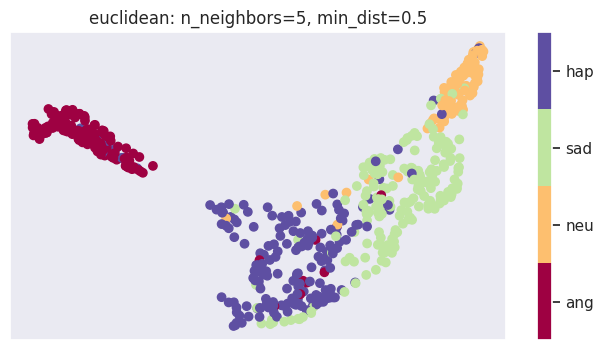

In [73]:
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(latents)
_ = transform_and_visualize_umap(
    transformer, data=latents, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

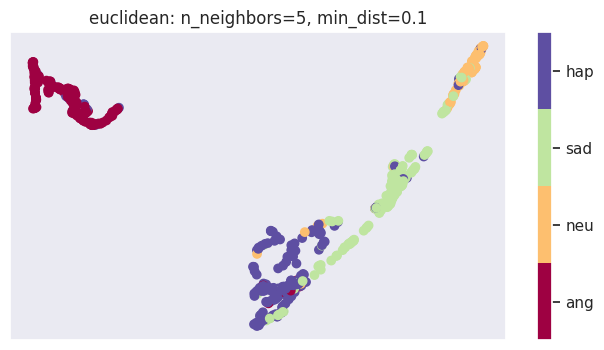

In [74]:
k = 5
min_dist = 0.1
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(latents)

_ = transform_and_visualize_umap(
    transformer, data=latents, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

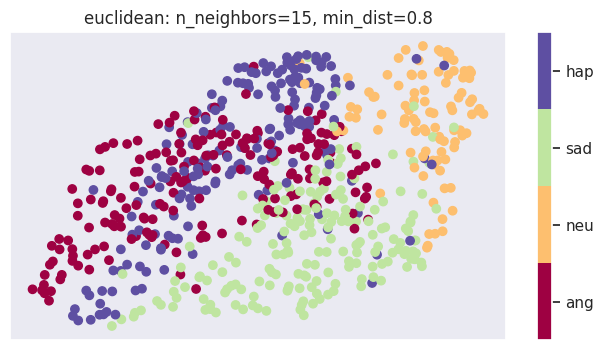

In [75]:
k = 15
min_dist = 0.8
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(latents)

_ = transform_and_visualize_umap(
    transformer, data=latents, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

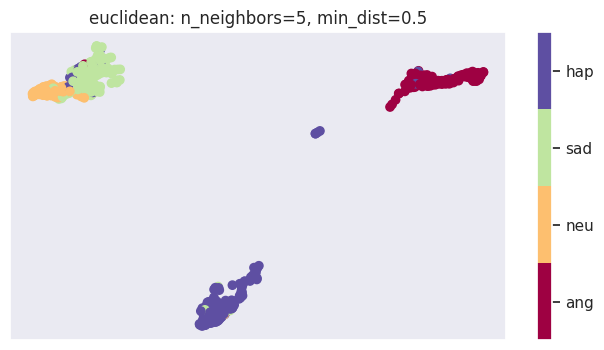

In [76]:
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(latents, data_y)

_ = transform_and_visualize_umap(
    transformer, data=latents, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

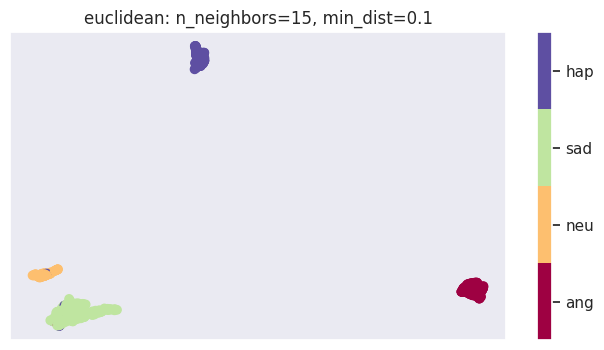

In [77]:
k = 15
min_dist = 0.1
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(latents, data_y)

_ = transform_and_visualize_umap(
    transformer, data=latents, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

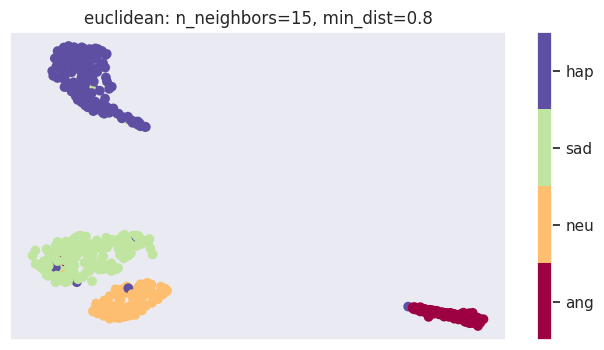

In [78]:
k = 15
min_dist = 0.8
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(latents, data_y)

_ = transform_and_visualize_umap(
    transformer, data=latents, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [68]:
data_x_emb_tensor = torch.tensor(data_x_emb)

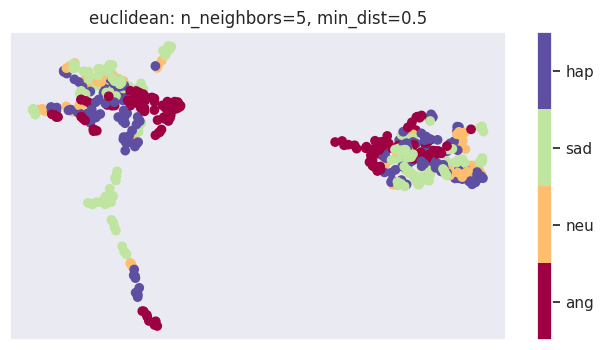

In [79]:
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(data_x_emb_tensor)

_ = transform_and_visualize_umap(
    transformer, data=data_x_emb_tensor, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

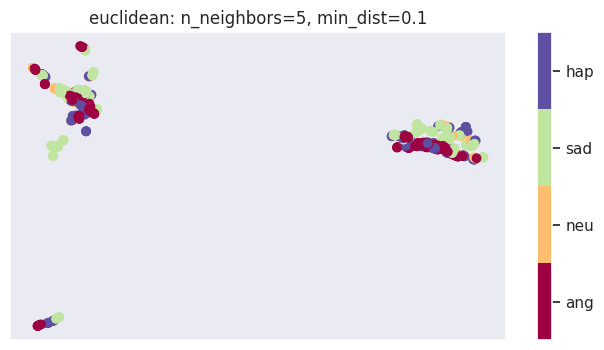

In [80]:
k = 5
min_dist = 0.1
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(data_x_emb_tensor)

_ = transform_and_visualize_umap(
    transformer, data=data_x_emb_tensor, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

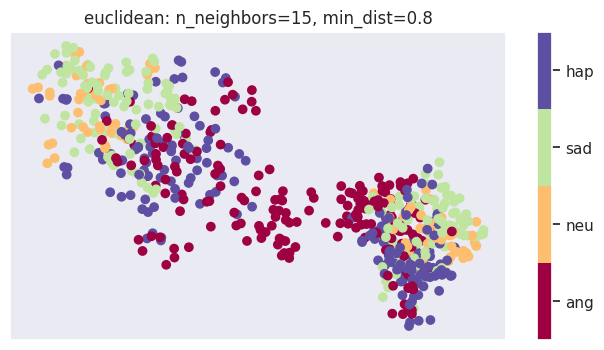

In [81]:
k = 15
min_dist = 0.8
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(data_x_emb_tensor)

_ = transform_and_visualize_umap(
    transformer, data=data_x_emb_tensor, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

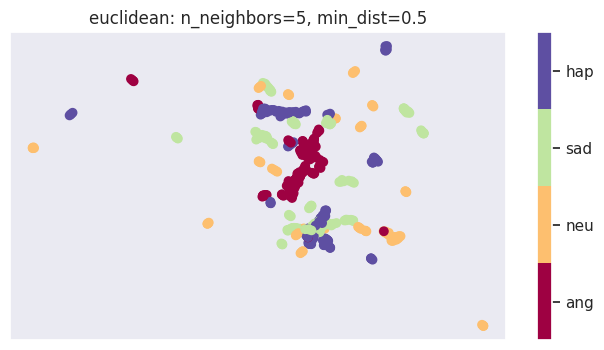

In [83]:
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(data_x_emb_tensor, data_y)

_ = transform_and_visualize_umap(
    transformer, data=data_x_emb_tensor, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

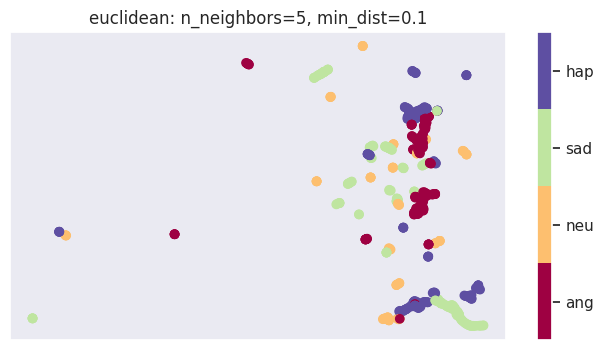

In [84]:
k = 5
min_dist = 0.1
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(data_x_emb_tensor, data_y)

_ = transform_and_visualize_umap(
    transformer, data=data_x_emb_tensor, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

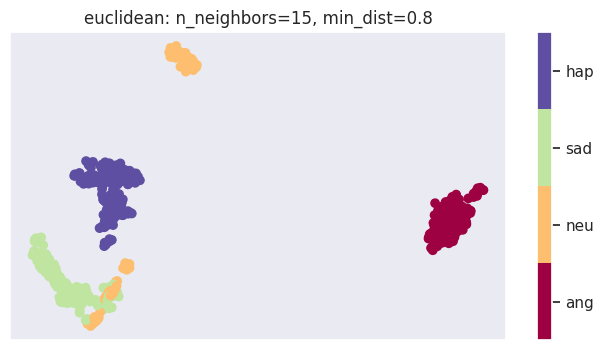

In [86]:
k = 15
min_dist = 0.8
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(data_x_emb_tensor, data_y)

_ = transform_and_visualize_umap(
    transformer, data=data_x_emb_tensor, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

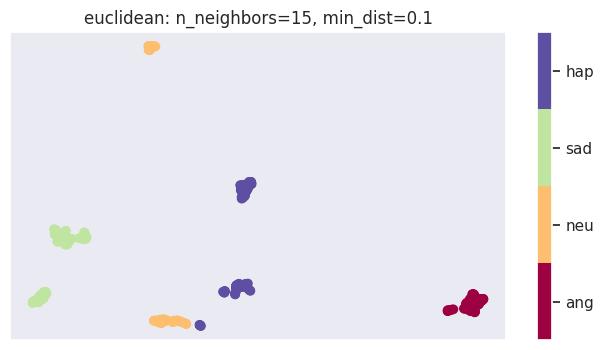

In [85]:
k = 15
min_dist = 0.1
umap_metric = 'euclidean'
n_components = 16
transformer = umap.UMAP(
        n_neighbors=k,
        min_dist=min_dist,
        n_components=n_components,
        metric=umap_metric)
transformer = transformer.fit(data_x_emb_tensor, data_y)

_ = transform_and_visualize_umap(
    transformer, data=data_x_emb_tensor, target=data_y, classnames=labels, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')